In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") 

Using device: cuda


In [3]:
# Load data
train_data = pd.read_csv("train.csv")
train_extra_data = pd.read_csv("training_extra.csv")
test_data = pd.read_csv("test.csv")

In [4]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB
None


In [5]:
print(train_extra_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 310.0+ MB
None


In [6]:
train_data.sample(10)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
125343,125343,Adidas,Leather,Small,10.0,No,No,Backpack,Green,15.341059,56.56349
19924,19924,Adidas,Polyester,Medium,8.0,Yes,Yes,Messenger,Green,21.637170,110.86241
62196,62196,Adidas,Canvas,Large,10.0,Yes,Yes,Backpack,NaN,14.715410,67.18898
234787,234787,Under Armour,Polyester,Large,5.0,Yes,No,Tote,Pink,20.875433,90.52863
110814,110814,Jansport,Leather,NaN,1.0,No,No,Messenger,Blue,20.856282,67.14502
60100,60100,Under Armour,Canvas,Small,7.0,No,Yes,Tote,Gray,11.145065,92.20530
203060,203060,Under Armour,Canvas,Small,2.0,No,No,Tote,Pink,21.917144,76.42038
29807,29807,Adidas,Polyester,Medium,9.0,No,Yes,Messenger,Green,28.865778,40.26745
12694,12694,Jansport,Leather,Large,9.0,Yes,Yes,Messenger,Red,29.559651,19.83005
239562,239562,Under Armour,Polyester,Large,7.0,No,Yes,Tote,Black,16.929313,103.32034


Text(0.5, 1.0, 'Price Dist.')

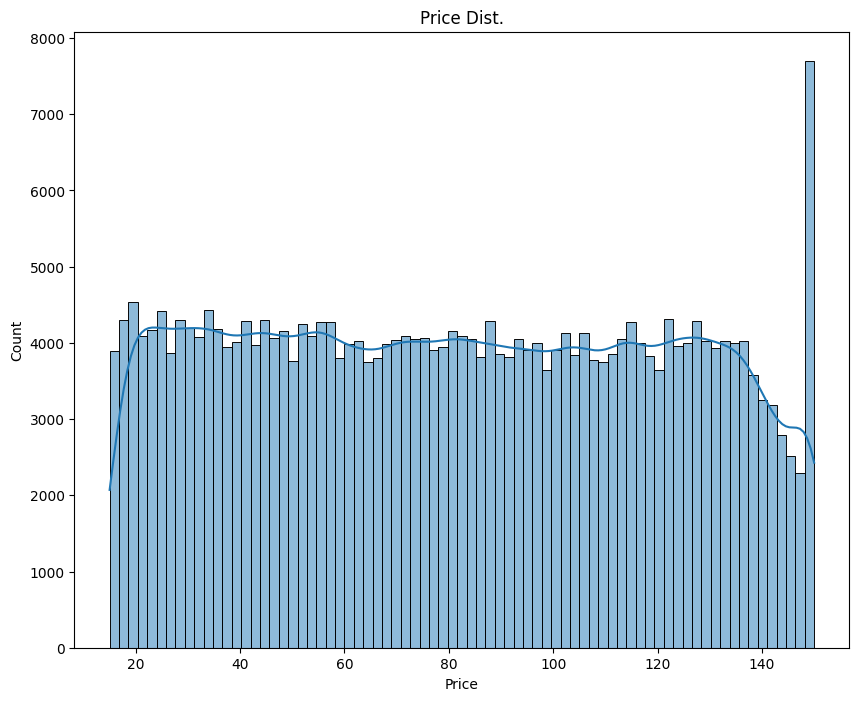

In [7]:
plt.figure(figsize=(10, 8))
sns.histplot(train_data["Price"], bins=75, kde=True)
plt.title("Price Dist.")

Lots of backpacks at $150 for some reason.

**Data cleaning time:** 

Since there are lots of features with missing categorical values, I will first try to impute them using K-nearest neighbors. If this doesn't seem to yield great results later, I will come back and try different methods for the missing data.

In [8]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

copy_train_data = train_data.copy()

# Fill missing numerical values with the mean
numer_cols = ["Weight Capacity (kg)"] # only numerical feature with missing data
for col in numer_cols:
    copy_train_data[col].fillna(copy_train_data[col].mean(), inplace=True)

# Convert categorical columns into numeric form for KNN
categ_cols = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]
label_encoders = {}

for col in categ_cols:
    le = LabelEncoder()
    # convert to string for label encoding
    copy_train_data[col] = copy_train_data[col].astype(str)
    # encode catergorical values
    copy_train_data[col] = le.fit_transform(copy_train_data[col])
    #store encoder for decoding later
    label_encoders[col] = le

knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
copy_train_data[categ_cols] = knn_imputer.fit_transform(copy_train_data[categ_cols])

# Convert categorical values back to original labels
for col in categ_cols:
    copy_train_data[col] = copy_train_data[col].astype(int)
    copy_train_data[col] = label_encoders[col].inverse_transform(copy_train_data[col])

C:\Users\ellio\AppData\Local\Temp\ipykernel_33152\2163509324.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  copy_train_data[col].fillna(copy_train_data[col].mean(), inplace=True)


In [9]:
copy_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 300000 non-null  object 
 2   Material              300000 non-null  object 
 3   Size                  300000 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    300000 non-null  object 
 6   Waterproof            300000 non-null  object 
 7   Style                 300000 non-null  object 
 8   Color                 300000 non-null  object 
 9   Weight Capacity (kg)  300000 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [10]:
for col in categ_cols:
    copy_train_data[col] = copy_train_data[col].astype(str)
    copy_train_data[col] = copy_train_data[col].fillna("Unknown")
    copy_train_data[col] = copy_train_data[col].replace("nan", "Unknown")

In [11]:
# OHE categorical features
OHE_df = pd.get_dummies(copy_train_data, columns=categ_cols, drop_first=True)

In [12]:
from sklearn.preprocessing import StandardScaler

num_cols = ["Compartments", "Weight Capacity (kg)"]
scaler = StandardScaler()

# standardize
OHE_df[num_cols] = scaler.fit_transform(OHE_df[num_cols])

In [13]:
# One hot encoding put true false values and I want 0, 1 so we must convert
OHE_df = OHE_df.map(lambda x: True if x == 'True' else (False if x == 'False' else x))

OHE_df = OHE_df.map(lambda x: 1 if x is True else (0 if x is False else x))

OHE_df = OHE_df.apply(pd.to_numeric, errors='coerce')

In [14]:
OHE_df.sample(10)

,id,Compartments,Weight Capacity (kg),Price,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Brand_Unknown,Material_Leather,...,Waterproof_Yes,Style_Messenger,Style_Tote,Style_Unknown,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red,Color_Unknown
119651,119651,1.576198,0.498420,38.96544,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
286585,286585,-0.499381,-0.432168,130.34004,0,1,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
99573,99573,0.884338,-0.958630,149.21206,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
66633,66633,0.884338,-1.028282,88.00703,0,1,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
231640,231640,1.230268,1.408993,89.50767,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
140874,140874,-1.191240,-1.326907,72.77151,0,1,0,0,0,1,...,1,1,0,0,0,0,0,1,0,0
125344,125344,-1.191240,1.280010,75.62481,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
83612,83612,0.538408,0.080912,62.44455,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
113031,113031,-0.153451,-1.669884,73.21583,0,0,0,1,0,1,...,0,1,0,0,0,1,0,0,0,0
128671,128671,1.230268,-0.370195,21.12426,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


I might want to drop the unknown columns later, but for now I will leave them in.

In [15]:
# I will put all the data preprocessing into a single function, because I also want 
# to clean and use the larger dataset for a DNN.

def clean_data(dataset):
    # Fill missing numerical values with the mean
    numer_cols = ["Weight Capacity (kg)"] # only numerical feature with missing data
    for col in numer_cols:
        dataset[col].fillna(dataset[col].mean(), inplace=True)

    # Convert categorical columns into numeric form for KNN
    categ_cols = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]
    label_encoders = {}

    for col in categ_cols:
        le = LabelEncoder()
        # convert to string for label encoding
        dataset[col] = dataset[col].astype(str)
        # encode catergorical values
        dataset[col] = le.fit_transform(dataset[col])
        #store encoder for decoding later
        label_encoders[col] = le

    knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
    dataset[categ_cols] = knn_imputer.fit_transform(dataset[categ_cols])

    # Convert categorical values back to original labels
    for col in categ_cols:
        dataset[col] = dataset[col].astype(int)
        dataset[col] = label_encoders[col].inverse_transform(dataset[col])

    for col in categ_cols:
        dataset[col] = dataset[col].astype(str)
        dataset[col] = dataset[col].fillna("Unknown")
        dataset[col] = dataset[col].replace("nan", "Unknown")

    # OHE categorical features
    OHE_df = pd.get_dummies(dataset, columns=categ_cols, drop_first=True)

    num_cols = ["Compartments", "Weight Capacity (kg)"]
    scaler = StandardScaler()

    # standardize
    OHE_df[num_cols] = scaler.fit_transform(OHE_df[num_cols])

    # One hot encoding put true false values and I want 0, 1 so we must convert
    OHE_df = OHE_df.map(lambda x: True if x == 'True' else (False if x == 'False' else x))

    OHE_df = OHE_df.map(lambda x: 1 if x is True else (0 if x is False else x))

    OHE_df = OHE_df.apply(pd.to_numeric, errors='coerce')

    return OHE_df

In [16]:
large_dataset = clean_data(train_extra_data.copy())

C:\Users\ellio\AppData\Local\Temp\ipykernel_33152\3103023210.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[col].fillna(dataset[col].mean(), inplace=True)


In [17]:
from sklearn.model_selection import train_test_split

# I don't want to keep typing OHE_df
df = OHE_df

X = df.drop(columns=["id", "Price"])
y = df["Price"]

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7) # 80/20 split

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

Training set: (240000, 27), Validation set: (60000, 27)


In [18]:
df[num_cols].describe()

,Compartments,Weight Capacity (kg)
count,3.000000e+05,3.000000e+05
mean,-1.243450e-16,1.709092e-16
std,1.000002e+00,1.000002e+00
min,-1.537170e+00,-1.870701e+00
25%,-8.453103e-01,-8.514935e-01
50%,-1.534510e-01,4.970913e-03
75%,8.843381e-01,8.572712e-01
max,1.576198e+00,1.718520e+00


First thing I want to try is RF

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

rf_model = RandomForestRegressor(n_estimators=100, random_state=7)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_val)

In [20]:
# Evaluate
rmse_rf = root_mean_squared_error(y_val, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf}")

Random Forest RMSE: 40.280771766553826


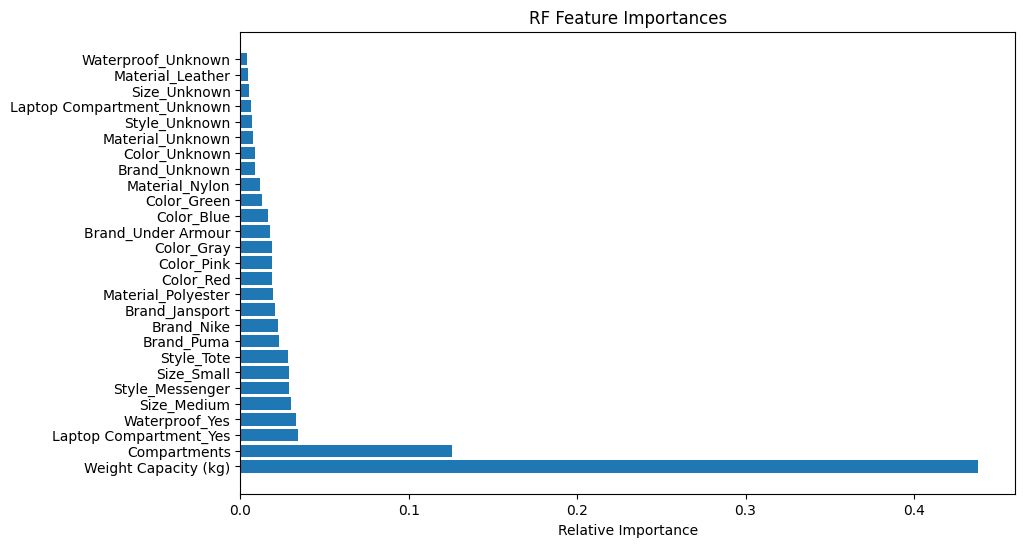

In [21]:
# I want to see feature importances for future info
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("RF Feature Importances")
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

Next let's try gradient boosting

In [22]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=7
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_val)

In [23]:
rmse_xgb = root_mean_squared_error(y_val, y_pred_xgb)
print(f"XGBoost RMSE: {rmse_xgb}")

XGBoost RMSE: 39.09907881794317


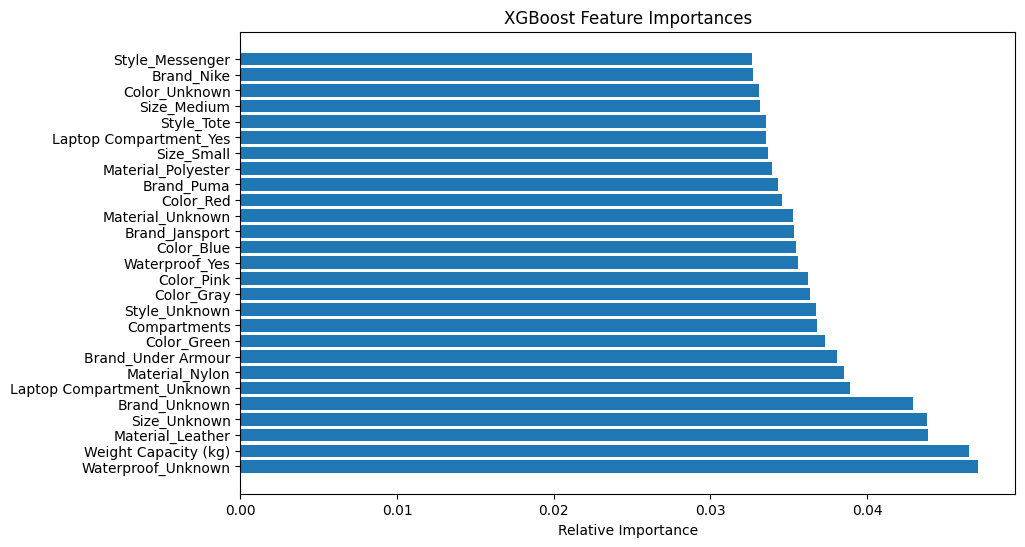

In [24]:
import matplotlib.pyplot as plt

xgb_importances = xgb_model.feature_importances_
indices = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("XGBoost Feature Importances")
plt.barh(range(X_train.shape[1]), xgb_importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [25]:
# I will try to optimize the XGBoost model, starting with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [200, 400, 600, 800],  
    'max_depth': [4, 6, 8, 10, 12],  
    'learning_rate': [0.005, 0.01, 0.03, 0.05, 0.1], 
    'subsample': [0.6, 0.75, 0.85, 1.0], 
    'colsample_bytree': [0.6, 0.75, 0.85, 1.0],  
    'reg_lambda': [0.1, 1, 10, 50, 100], 
    'reg_alpha': [0, 0.1, 1, 10, 50]  
}

xgb_model2 = xgb.XGBRegressor(random_state=7)

# randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_model2,
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=4 # could amp it up a notch if needed
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# train new model
xgb_best = xgb.XGBRegressor(**best_params, random_state=7)
xgb_best.fit(X_train, y_train)

# predict and evaluate
y_pred_xgb_best = xgb_best.predict(X_val)
rmse_xgb_best = root_mean_squared_error(y_val, y_pred_xgb_best)
print(f"Tuned XGBoost RMSE: {rmse_xgb_best}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'subsample': 0.85, 'reg_lambda': 0.1, 'reg_alpha': 10, 'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.005, 'colsample_bytree': 0.75}
Tuned XGBoost RMSE: 39.08244721603137


Now I'd like to try using deep learning to see if we can do better than an RMSE of 39.08

In [26]:
X = large_dataset.drop(columns=["id", "Price"])
y = large_dataset["Price"]

# Split data
X_train_big, X_val_big, y_train_big, y_val_big = train_test_split(X, y, test_size=0.2, random_state=7) # 80/20 split

In [27]:
# torchtime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train_big.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_big.values, dtype=torch.float32).view(-1, 1).to(device)

X_val_tensor = torch.tensor(X_val_big.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_big.values, dtype=torch.float32).view(-1, 1).to(device)

In [28]:
# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [29]:
class BackpackPricePredictor(nn.Module):
    def __init__(self, input_dim):
        super(BackpackPricePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm1d(256),
            nn.Dropout(0.35),  # Dropout added (30%)
            
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm1d(128),
            nn.Dropout(0.35),

            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm1d(64),
            nn.Dropout(0.35),

            nn.Linear(64, 32),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(32, 1)  # Output layer
        )

    def forward(self, x):
        return self.model(x)

In [30]:
import torch.optim.lr_scheduler as lr_scheduler
input_dim = X_train.shape[1] 
model = BackpackPricePredictor(input_dim)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Lowered learning rate
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [31]:
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

Epoch 1/15, Training Loss: 1856.3857, Validation Loss: 1516.5456
Epoch 2/15, Training Loss: 1564.4785, Validation Loss: 1515.9362
Epoch 3/15, Training Loss: 1537.6195, Validation Loss: 1514.3487
Epoch 4/15, Training Loss: 1522.1910, Validation Loss: 1515.8288
Epoch 5/15, Training Loss: 1517.0158, Validation Loss: 1514.7675
Epoch 6/15, Training Loss: 1515.2147, Validation Loss: 1515.0570
Epoch 7/15, Training Loss: 1514.3867, Validation Loss: 1514.3428
Epoch 8/15, Training Loss: 1513.9272, Validation Loss: 1513.6289
Epoch 9/15, Training Loss: 1513.5750, Validation Loss: 1513.7191
Epoch 10/15, Training Loss: 1513.3786, Validation Loss: 1513.4224
Epoch 11/15, Training Loss: 1513.1962, Validation Loss: 1513.5234
Epoch 12/15, Training Loss: 1513.0697, Validation Loss: 1513.8055
Epoch 13/15, Training Loss: 1512.8933, Validation Loss: 1513.4034
Epoch 14/15, Training Loss: 1512.8082, Validation Loss: 1513.2682
Epoch 15/15, Training Loss: 1512.8058, Validation Loss: 1513.1641


In [33]:
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val_tensor)

rmse_dl = torch.sqrt(torch.mean((y_pred_val - y_val_tensor) ** 2)).item()
print(f"Deep Learning Model RMSE: {rmse_dl}")

Deep Learning Model RMSE: 38.90222930908203
